# <b>데이터 전처리</b> Preprocessing

##### 라이브러리

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## <b>1.0 데이터 불러오기</b>

In [76]:
# 실습용자료 불러와 csv로 저장, DataFrame으로 불러오기

# train = pd.read_table("./data/1. 실습용자료.txt", encoding='CP949', sep='|')
# train.to_csv('./data/train.csv', index=False)


#  불러와 csv로 저장, DataFrame으로 불러오기

# test = pd.read_table("./data/2. 모델개발용자료.txt", encoding='CP949', sep='|')
# test.to_csv('./data/test.csv', index=False)


In [3]:
# 데이터 불러오기

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## <b>2.0 데이터 탐색</b>

In [4]:
print(train.head(), '\n')

print(test.head())

# 일련번호(AI_id), 산업대분류(digit_1), 산업중분류(digit_2), 산업소분류(digit_3), 사업 대상(text_obj), 사업 방법(text_mthd), 사업 취급품목(text_deal)


        AI_id digit_1  digit_2  digit_3    text_obj    text_mthd text_deal
0  id_0000001       S       95      952       카센터에서      자동차부분정비   타이어오일교환
1  id_0000002       G       47      472       상점내에서    일반인을 대상으로   채소.과일판매
2  id_0000003       G       46      467  절단하여사업체에도매    공업용고무를가지고    합성고무도매
3  id_0000004       G       47      475       영업점에서      일반소비자에게    열쇠잠금장치
4  id_0000005       Q       87      872        어린이집  보호자의 위탁을 받아   취학전아동보육 

       AI_id  digit_1  digit_2  digit_3  text_obj  text_mthd text_deal
0  id_000001      NaN      NaN      NaN   치킨전문점에서   고객의주문에의해      치킨판매
1  id_000002      NaN      NaN      NaN      산업공구  다른 소매업자에게    철물 수공구
2  id_000003      NaN      NaN      NaN       절에서   신도을 대상으로    불교단체운영
3  id_000004      NaN      NaN      NaN     영업장에서      고객요구로     자동차튜닝
4  id_000005      NaN      NaN      NaN  실내포장마차에서  접객시설을 갖추고   소주,맥주제공


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  int64 
 3   digit_3    1000000 non-null  int64 
 4   text_obj   983323 non-null   object
 5   text_mthd  956381 non-null   object
 6   text_deal  932348 non-null   object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AI_id      100000 non-null  object 
 1   digit_1    0 non-null       float64
 2   digit_2    0 non-null       float64
 3   digit_3    0 non-null       float64
 4   text_obj   98189 non-null   object 
 5   text_mthd  97032 non-null   object 
 6   text_deal  93839 non-null   object 
dtypes: float64(3), object(4)
memory usage: 5.3+ MB


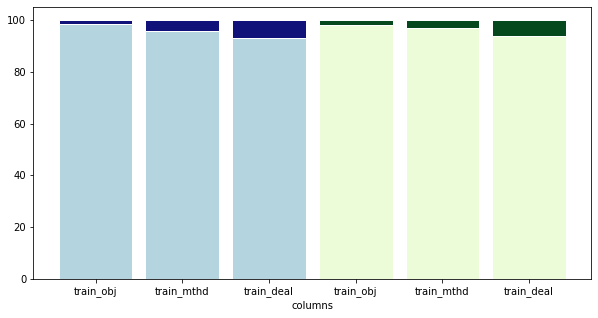

In [40]:
# 널값 비율

# Data
r1 , r2 = [0,1,2], [3,4,5] # for X row

train_data = {'notnull': [train['text_obj'].count(), train['text_mthd'].count(), train['text_deal'].count()],
            'isnull': [train['text_obj'].isnull().sum(), train['text_mthd'].isnull().sum(), train['text_deal'].isnull().sum()]}
test_data = {'notnull': [test['text_obj'].count(), test['text_mthd'].count(), test['text_deal'].count()],
            'isnull': [test['text_obj'].isnull().sum(), test['text_mthd'].isnull().sum(), test['text_deal'].isnull().sum()]}

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
 
# From raw value to percentage
# for train
train_totals = [i+j for i,j in zip(train_data['notnull'], train_data['isnull'])]
train_notnull = [i / j * 100 for i,j in zip(train_data['notnull'], train_totals)]
train_isnull = [i / j * 100 for i,j in zip(train_data['isnull'], train_totals)]
# for test
test_totals = [i+j for i,j in zip(test_data['notnull'], test_data['isnull'])]
test_notnull = [i / j * 100 for i,j in zip(test_data['notnull'], test_totals)]
test_isnull = [i / j * 100 for i,j in zip(test_data['isnull'], test_totals)]
 
# plot
plt.figure(figsize=(10, 5))
barWidth = 0.85

# Create train bars
plt.bar(r1, train_notnull, color='#B4D4DF', edgecolor='white', width=barWidth)
plt.bar(r1, train_isnull, bottom=train_notnull, color='#11117A', edgecolor='white', width=barWidth)

# Create text bars
plt.bar(r2, test_notnull, color='#EDFCD8', edgecolor='white', width=barWidth)
plt.bar(r2, test_isnull, bottom=test_notnull, color='#06481D', edgecolor='white', width=barWidth)

# Custom x axis
names = ('train_obj','train_mthd','train_deal','train_obj','train_mthd', 'train_deal')
plt.xticks(r1+r2, names)
plt.xlabel("columns")
 
# Show graphic
plt.show()

## <b>3.0 데이터 정제</b>

### 결측치 처리

## <b>4.0 토큰화</b>

## <b>5.0 인코딩</b>

## <b>6.0 패딩</b>